In [2761]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sn 

In [2762]:
np.random.seed(1)

In [2763]:
p = 20
# create twenty vectors of numbers designed to be the principal components of a degenerate normal distribution
G = stats.ortho_group.rvs(dim=p)
#create covariance matrix of the vectors
c = np.diag(np.array([20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]))


In [2764]:
covariance_matrix = np.matmul(np.matmul(G, c),G.T)
X = np.random.multivariate_normal(np.zeros(p), covariance_matrix, 200)
pca = np.linalg.eig(np.cov(X.T))

In [2765]:
init_G = pca.eigenvectors
init_c = np.diag(pca.eigenvalues)

In [2766]:
init_c

array([[23.22736532,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 19.93530791,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 19.34510189,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 18.95692432,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [2767]:
sort_c = np.argsort(np.diag(init_c))[::-1]

In [2768]:
init_G = init_G[:,sort_c]
init_c = init_c[sort_c,:][:,sort_c]

<Axes: >

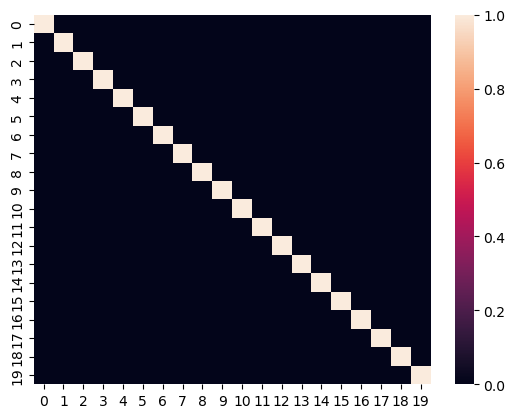

In [2769]:
sn.heatmap(G@G.T)   

In [2770]:
data = np.random.multivariate_normal(np.zeros(p), covariance_matrix, 100)

<Axes: >

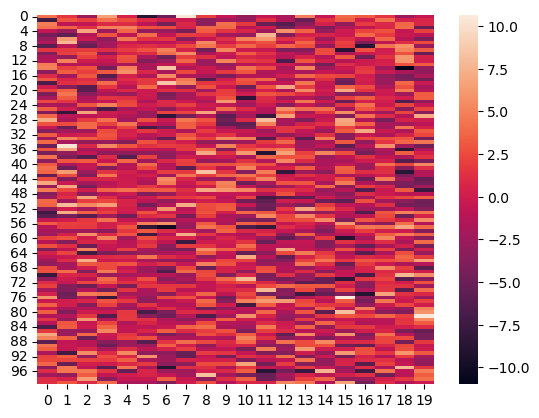

In [2771]:
sn.heatmap(data)

In [2772]:
class Gibbs_Sampler(object):
    def __init__(self, data, n_components,tau, n_iter, burn_in, init_G, init_norm_G):
        self.n_components = n_components
        self.G_storage = np.repeat(np.expand_dims(init_G[:,0:self.n_components],2),n_iter,axis=2)
        self.norm_G_storage = np.repeat(np.expand_dims(init_norm_G[0:self.n_components,0:self.n_components],2),n_iter,axis=2)
        self.data = data
        self.G_interim= init_G
        self.G = init_G[:,0:self.n_components]
        self.norm_G_interim = init_norm_G
        self.norm_G = init_norm_G[0:self.n_components,0:self.n_components]
        self.n = data.shape[1]
        self.n_iter = n_iter
        self.burn_in = burn_in
        self.sort = []
        self.tau = tau
    def norm_G_Update(self):
        scale = 1/(.5 + .5*np.sum(np.power(np.divide(np.dot(self.data, self.G_interim),np.diag(np.dot(self.G_interim.T,self.G_interim))),2),axis=0))
        shape = self.n_components/2 +self.n/2
        rvs= stats.gamma.rvs(shape, scale)
        self.sort = np.argsort(rvs)[::-1]
        self.norm_G_interim = np.diag(rvs[self.sort])
        self.norm_G =self.norm_G_interim[0:self.n_components,0:self.n_components]
            
    def G_Update(self):
        xTx = np.dot(self.data[:,self.sort].T,self.data[:,self.sort])
        xTx = xTx[0:self.n_components,0:self.n_components]
        accept= False
        count = 0
        while accept==False:
            count+=1
            #print(inv_pdfval)
            cutoff= np.log(np.random.uniform(size=1))

            self.hold_G = stats.matrix_normal.rvs(self.G, np.linalg.inv(xTx), np.linalg.inv(self.norm_G_interim[0:self.n_components,0:self.n_components]))
            mean_G = self.hold_G
            for i in range(1, self.n_components):
                projection =np.dot(mean_G[:,i],np.squeeze(mean_G[:,0:i]))
                norm = np.array(np.dot(np.squeeze(mean_G[:,0:i].T),np.squeeze(mean_G[:,0:i])))         
                if projection.shape != () and projection.shape != (0,):
                    projection = np.diag(projection)
                if norm.shape != () and norm.shape != (0,):
                    norm= np.diag(np.diag(1/np.array(norm)))
                    projectionnorm = np.matmul(projection,norm)
                else:
                    projectionnorm = projection/norm
                test1 = mean_G[:,0:i]
                test2 = projection
                test3 = norm
                if i >= 2:
                    mean_G[:,i] = mean_G[:,i] - np.sum(np.matmul(test1,projectionnorm),1)
                elif i==1:
                    mean_G[:,i] = np.squeeze(mean_G[:,i]) - np.squeeze(test1)*projectionnorm
            norm = np.diag(np.array(np.dot(np.squeeze(mean_G[:,:].T),np.squeeze(mean_G[:,:]))))
            for i in range(self.n_components):
                mean_G[:,i] = mean_G[:,i]/np.linalg.norm(mean_G[:,i])
            #print(mean_G@self.norm_G[0:self.n_components,0:self.n_components]@mean_G.T)
            #print(stats.multivariate_normal.logpdf(self.data, cov=mean_G@self.norm_G[0:self.n_components,0:self.n_components]@mean_G.T).shape)
            #upper = np.sum(stats.multivariate_normal.logpdf(self.data, cov=mean_G.T@self.norm_G[0:self.n_components,0:self.n_components]@mean_G))-np.sum(stats.multivariate_normal.logpdf(self.data, cov=self.G.T@self.norm_G[0:self.n_components,0:self.n_components]@self.G))
            upper=(np.matrix.trace(np.matmul(np.matmul(np.matmul(xTx,mean_G),self.norm_G[0:self.n_components,0:self.n_components]),mean_G.T))-np.matrix.trace(np.matmul(np.matmul(np.matmul(xTx,self.G,),self.norm_G[0:self.n_components,0:self.n_components]),self.G.T)))
            #print(upper)
            #print(cutoff)
            if cutoff <  upper:
                accept = True
        self.G = mean_G[:,0:self.n_components]
    def _sample_parameters(self):
        for iter in range(self.n_iter+self.burn_in):
            self.norm_G_Update()
            self.G_Update()
            if iter%100==0:
                print(iter)
            if iter >= self.burn_in:
                self.norm_G_storage[:,:,iter-self.burn_in] = self.norm_G
                self.G_storage[:,:,iter-self.burn_in] = self.G


In [2773]:
data.shape

(100, 20)

In [2834]:
test = Gibbs_Sampler(X, 20,100, 10000,10000, init_G, init_c)

In [2835]:
test.norm_G_Update()

In [2836]:
test.G_Update()

<Axes: >

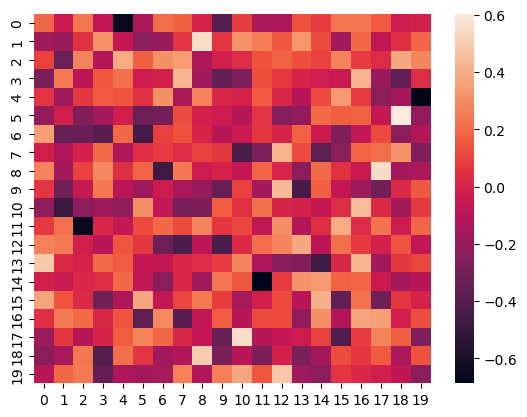

In [2837]:
sn.heatmap(test.G)

<Axes: >

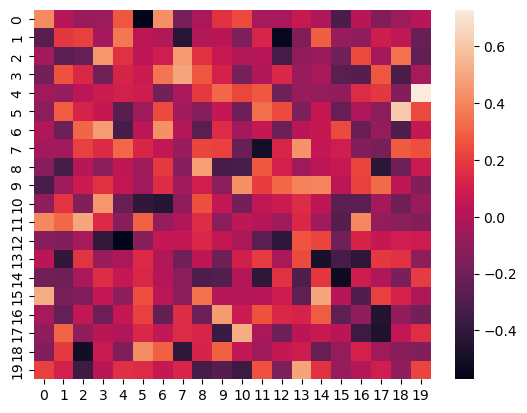

In [2838]:
sn.heatmap(G)

In [2839]:
test._sample_parameters()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [2840]:
sampled_cov = np.median(np.transpose(test.G_storage,[2,0,1])@np.transpose(test.norm_G_storage,[2,0,1])@np.transpose(test.G_storage,[2,1,0]),0) 

In [2841]:
np.diag(sampled_cov)

array([19.54022242, 20.0628646 , 19.88923956, 19.91072938, 20.51575681,
       19.95628208, 18.70827615, 19.83212226, 19.36142691, 19.49501283,
       19.54272192, 20.07244299, 19.7596956 , 21.18807689, 20.8791812 ,
       19.69100214, 20.93570997, 20.00922821, 20.0975958 , 19.88813101])

<Axes: >

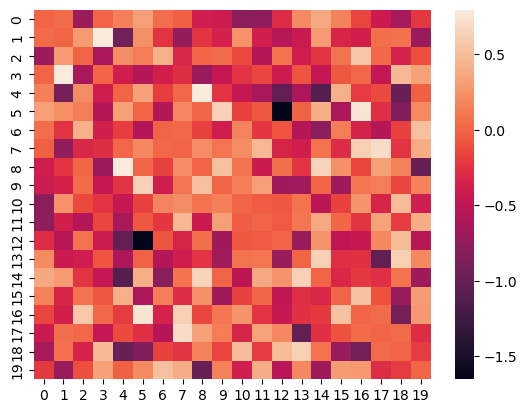

In [2842]:
sn.heatmap(sampled_cov - np.diag(np.diag(sampled_cov)))

<Axes: >

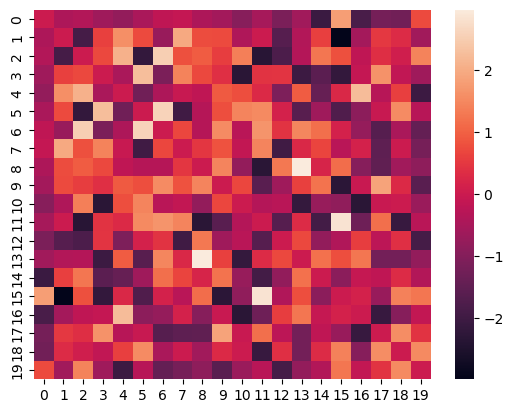

In [2843]:
sn.heatmap(covariance_matrix - np.diag(np.diag(covariance_matrix)))

<Axes: >

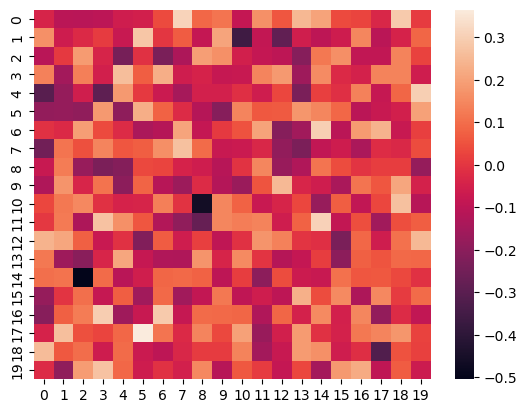

In [2844]:
sn.heatmap(np.median(test.G_storage,2))

<Axes: >

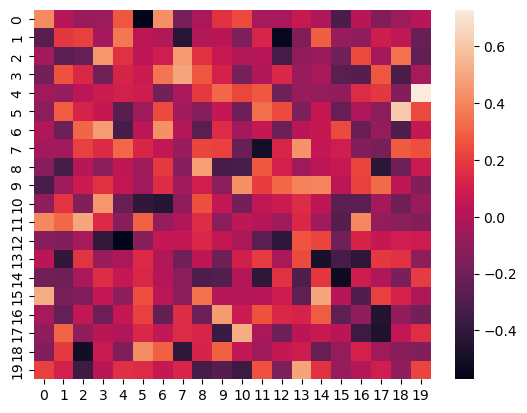

In [2845]:
sn.heatmap(G)

<Axes: >

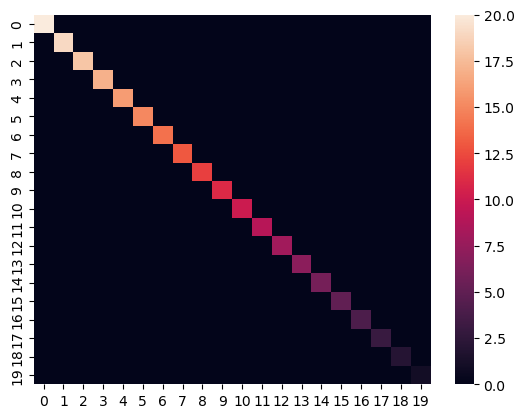

In [2846]:
sn.heatmap(c)

<Axes: >

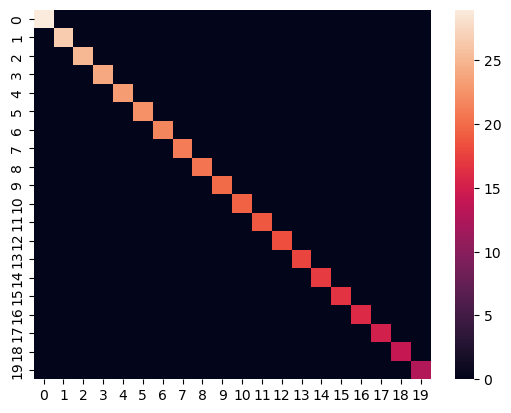

In [2847]:
sn.heatmap(np.median(test.norm_G_storage,2))

<Axes: >

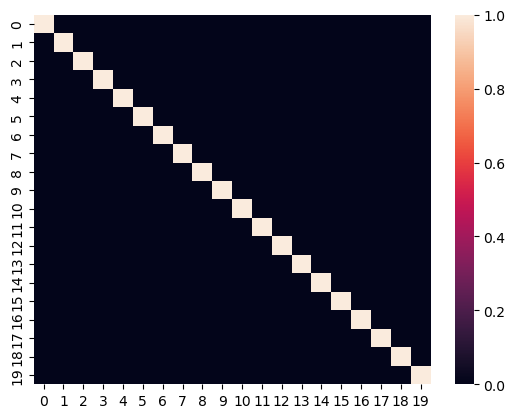

In [2848]:
sn.heatmap(np.median(np.transpose(test.G_storage,[2,0,1])@np.transpose(test.G_storage,[2,1,0]),0))

In [2855]:
pc_index = 0
first_pc = test.G_storage[:,pc_index,:]

In [2856]:
median_first_pc = np.quantile(first_pc,.5,axis=1)
quantile_75 = np.quantile(first_pc, .95, axis=1)
quantile_25 = np.quantile(first_pc, .05, axis=1)
truth = G[:,pc_index]

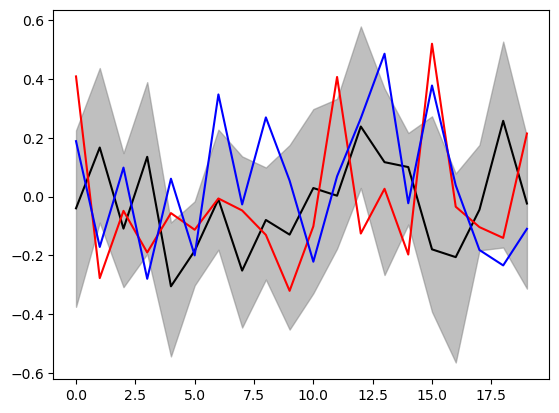

In [2857]:
plt.fill_between(range(p),quantile_25,quantile_75, color = 'gray', alpha = .5)
plt.plot(range(p), median_first_pc, color = 'black')
plt.plot(range(p), truth, color = 'red')
plt.plot(range(p), init_G[:,pc_index], color = 'blue')

In [2852]:
np.diag(init_c)

array([23.22736532, 19.93530791, 19.34510189, 18.95692432, 17.16470427,
       14.01894359, 12.929924  , 11.89726192, 11.23668104, 10.16796955,
        8.67749188,  7.88213639,  7.43569969,  6.6843161 ,  5.89917976,
        4.6212892 ,  3.7940291 ,  2.62269521,  1.62006227,  0.80882394])

(array([ 236.,  867., 1071.,  924., 1423., 1310., 1476., 1668.,  859.,
         166.]),
 array([-0.37821514, -0.32740977, -0.2766044 , -0.22579902, -0.17499365,
        -0.12418828, -0.07338291, -0.02257753,  0.02822784,  0.07903321,
         0.12983858]),
 <BarContainer object of 10 artists>)

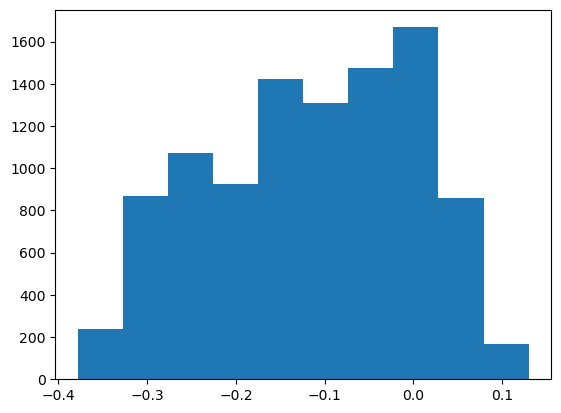

In [2853]:
plt.hist(test.G_storage[0,pc_index,:])

In [2854]:
G[0,pc_index]

0.01604851911546421

In [ ]:
# -*- coding: utf-8 -*-
from math import isinf
import numpy as np

def DictParts(m, n):
    D = []
    Last = np.array([[0], [m], [m]])
    end = 0
    for i in range(n):
        NewLast = np.empty((3, 0), dtype=int)
        ncol = Last.shape[1]
        for j in range(ncol):
            record = Last[:, j]
            lack = record[1]
            l = min(lack, record[2])
            if l > 0 :
                D.append((record[0]+1, end+1))
                x = np.empty((3, l), dtype=int)
                for k in range(l):
                    x[:, k] = np.array([end+k+1, lack-k-1, k+1])
                NewLast = np.hstack((NewLast, x))
                end += l
        Last = NewLast
    return (dict(D), end)
   
def _N(dico, kappa):
    kappa = kappa[kappa > 0]
    l = len(kappa)
    if l == 0:
        return 1
    return dico[_N(dico, kappa[:(l-1)])] + kappa[-1] 

def _T(alpha, a, b, kappa):
    i = len(kappa)
    if i == 0 or kappa[0] == 0:
        return 1
    c = kappa[-1] - 1 - (i - 1) / alpha
    d = alpha * kappa[-1] - i
    s = np.asarray(range(1, kappa[-1]), dtype=int)
    e = d - alpha * s + np.array(
        list(map(lambda j: np.count_nonzero(kappa >= j), s))
    )
    g = e + 1
    ss = range(i-1)
    f = alpha * kappa[ss] - (np.asarray(ss) + 1) - d
    h = alpha + f
    l = h * f
    prod1 = np.prod(a + c)
    prod2 = np.prod(b + c)
    prod3 = np.prod((g - alpha) * e / (g * (e + alpha)))
    prod4 = np.prod((l - f) / (l + h))
    out = prod1 / prod2 * prod3 * prod4
    return 0 if isinf(out) or np.isnan(out) else out


def betaratio(kappa, mu, k, alpha):
    muk = mu[k-1]
    t = k - alpha * muk
    prod1 = prod2 = prod3 = 1
    if k > 0:
        u = np.array(
            list(map(lambda i: t + 1 - i + alpha * kappa[i-1], range(1,k+1)))
        )
        prod1 = np.prod(u / (u + alpha - 1))
    if k > 1:
        v = np.array(
            list(map(lambda i: t - i + alpha * mu[i-1], range(1, k)))
        )
        prod2 = np.prod((v + alpha) / v)
    if muk > 1:
        muPrime = dualPartition(mu)
        w = np.array(
            list(map(lambda i: muPrime[i-1] - t - alpha * i, range(1, muk)))
        )
        prod3 = np.prod((w + alpha) / w)
    return alpha * prod1 * prod2 * prod3

def dualPartition(kappa):
    out = []
    if len(kappa) > 0 and kappa[0] > 0:
        for i in range(1, kappa[0]+1):
            out.append(np.count_nonzero(kappa >= i))
    return np.asarray(out, dtype=int)


def hypergeomI(m, alpha, a, b, n, x):
    def summation(i, z, j, kappa):
        def go(kappai, zz, s):
            if i == 0 and kappai > j or i > 0 and kappai > min(kappa[i-1], j):
                return s
            kappap = np.vstack((kappa, [kappai]))
            t = _T(alpha, a, b, kappap[kappap > 0])
            zp = zz * x * (n - i + alpha * (kappai -1)) * t
            sp = s
            if j > kappai and i <= n:
                sp += summation(i+1, zp, j - kappai, kappap)
            spp = sp + zp
            return go(kappai + 1, zp, spp)
        return go(1, z, 0)
    return 1 + summation(0, 1, m, np.empty((0,1), dtype=int))

def is_square_matrix(x):
    x = np.asarray(x)
    return x.ndim == 2 and x.shape[0] == x.shape[1]

def hypergeomPQ(m, a, b, x, alpha=2):
    """Hypergeometric function of a matrix argument.
    
    :param m: truncation weight of the summation, a positive integer
    :param a: the "upper" parameters, a numeric or complex vector, possibly empty (or `None`)
    :param b: the "lower" parameters, a numeric or complex vector, possibly empty (or `None`)
    :param x: a numeric or complex vector, the eigenvalues of the matrix
    :param alpha: the alpha parameter, a positive number
    
    """
    if a is None or len(a) == 0:
        a = np.array([])
    else:
        a = np.asarray(a)
    if b is None or len(b) == 0:
        b = np.array([])
    else:
        b = np.asarray(b)
    x = np.asarray(x)
    n = len(x)
    if all(x == x[0]):
        return hypergeomI(m, alpha, a, b, n, x[0])
    def jack(k, beta, c, t, mu, jarray, kappa, nkappa):
        lmu = len(mu)
        for i in range(max(1, k), (np.count_nonzero(mu)+1)):
            u = mu[i-1]
            if lmu == i or u > mu[i]:
                gamma = beta * betaratio(kappa, mu, i, alpha)
                mup = mu.copy()
                mup[i-1] = u - 1
                mup = mup[mup > 0]
                if len(mup) >= i and u > 1:
                    jack(i, gamma, c + 1, t, mup, jarray, kappa, nkappa)
                else:
                    if nkappa > 1:
                        if len(mup) > 0:
                            jarray[nkappa-1, t-1] += (
                                gamma * jarray[_N(dico, mup)-2, t-2] 
                                * x[t-1]**(c+1)
                            )
                        else:
                            jarray[nkappa-1, t-1] += gamma * x[t-1]**(c+1)
        if k == 0:
            if nkappa > 1:
                jarray[nkappa-1, t-1] += jarray[nkappa-1, t-2]
        else:
            jarray[nkappa-1, t-1] += (
                beta * x[t-1]**c * jarray[_N(dico, mu)-2, t-2]
            )
    def summation(i, z, j, kappa, jarray):
        def go(kappai, zp, s):
            if (
                    i == n or i == 0 and kappai > j 
                    or i > 0 and kappai > min(kappa[-1], j)
                ):
                return s
            kappap = np.concatenate((kappa, [kappai]))
            nkappa = _N(dico, kappap) - 1
            zpp = zp * _T(alpha, a, b, kappap)
            if nkappa > 1 and (len(kappap) == 1 or kappap[1] == 0):
                 jarray[nkappa-1, 0] = (
                     x[0] * (1 + alpha * (kappap[0] - 1)) * jarray[nkappa-2, 0]
                 )
            for t in range(2, n+1):
                jack(0, 1.0, 0, t, kappap, jarray, kappap, nkappa)
            sp = s + zpp * jarray[nkappa-1, n-1]
            if j > kappai and i <= n:
                spp = summation(i+1, zpp, j-kappai, kappap, jarray)
                return go(kappai+1, zpp, sp + spp)
            return go(kappai+1, zpp, sp)
        return go(1, z, 0)
    (dico, Pmn) = DictParts(m, n)
    T = type(x[0])
    J = np.zeros((Pmn, n), dtype=T)
    J[0, :] = np.cumsum(x)
    return 1 + summation(0, T(1), m, np.empty(0, dtype=int), J)

In [ ]:
test2 = hypergeomPQ(15, np.array([p/2]), np.array([p/2]), np.diag(test.norm_G_interim), alpha=2)

In [ ]:
print(np.log(test2))

57.34181229955998
